In [3]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels as sm
import folium
import sys
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import ccf, ccovf
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import warnings 
warnings.filterwarnings('ignore')

__Introduction__

In this part, we will provide the recommended model for the COVID-19 prediction in selected states (New York, California, and etc).

__Importing Data__

In [4]:
df_covid = pd.read_csv("us_daily_processed.csv")
us_state_date_confirmed = df_covid.groupby(['Province_State','date'])['Confirmed'].sum().reset_index()
us_state_date_death = df_covid.groupby(['Province_State','date'])['Deaths'].sum().reset_index()
df_confirmed_bystate = pd.DataFrame(us_state_date_confirmed)
df_death_bystate = pd.DataFrame(us_state_date_death)
df_temp= pd.read_csv("COVID_19_us_temp.csv")
df_temp= df_temp.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
df_temp_bystate=df_temp.groupby(["Province_State","date"])['Avg','Confirmed','Deaths'].sum().reset_index()
df_temp_bystate=pd.DataFrame(df_temp_bystate)

## Recommended Model for Predicting COVID-19 Cases

Following codes are the implementation of ARIMA process. We only provide the predictions and the visualization for prediction on test data to as a brief summary.

In [8]:
def ARIMA_covid_confirmed(state,p,d,q):
    df_confirmed_s=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    series = df_confirmed_s['Confirmed']
    y = series.values

    ts_df=pd.DataFrame(y,columns=['Confirmed'])
    n_sample = ts_df.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    #ts_df
    ts_train = ts_df.iloc[:n_train]['Confirmed']
    ts_test = ts_df.iloc[n_train:]['Confirmed']
    
    history = [x for x in ts_train]
    model = ARIMA(history,order=(p,d,q),)
    model_fit = model.fit(disp=0)
    predictions = model_fit.forecast(steps=len(ts_test))[0]
    
    for i in range(len(ts_test)):
        print('predicted=%f, expected=%f' % (int(predictions[i]), int(ts_test[i+len(ts_train)])))
    ts_pred=[]
    ts_true=[]
    for i in range(len(ts_train)):
        t1=0
        t2=ts_train[i]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+t2))
    for i in range(len(ts_train),n_sample):
        t1=0
        t2=predictions[i-len(ts_train)]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+ts_test[i])) 
    plt.plot(ts_pred,'r',label='Predicted Cases')
    plt.plot(ts_true,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Cases')
    plt.title('Out of Sample Prediction COVID-19 Confirmed Cases in '+state)
    plt.legend()
    plt.show()  

def ARIMA_covid_death(state,p,d,q):
    df_death_s=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    series = df_death_s['Deaths']
    y = series.values
    
    ts_df=pd.DataFrame(y,columns=['Deaths'])
    n_sample = ts_df.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    #ts_df
    ts_train = ts_df.iloc[:n_train]['Deaths']
    ts_test = ts_df.iloc[n_train:]['Deaths']
    
    history = [x for x in ts_train]
    model = ARIMA(history,order=(p,d,q))
    model_fit = model.fit(disp=0)
    predictions = model_fit.forecast(steps=len(ts_test))[0]
    
    for i in range(len(ts_test)):
        print('predicted=%f, expected=%f' % (int(predictions[i]), int(ts_test[i+len(ts_train)])))
    ts_pred=[]
    ts_true=[]
    for i in range(len(ts_train)):
        t1=0
        t2=ts_train[i]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+t2))
    for i in range(len(ts_train),n_sample):
        t1=0
        t2=predictions[i-len(ts_train)]
        ts_pred.append(int(t1+t2))
        ts_true.append(int(t1+ts_test[i])) 
    plt.plot(ts_pred,'r',label='Predicted Cases')
    plt.plot(ts_true,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Deaths Cases')
    plt.title('Out of Sample Prediction COVID-19 Death Cases in '+state)
    plt.legend()
    plt.show()  
    
def select_data(state):
    df1=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    return df1

def ARIMA_with_temp(state,p2,d2,q2):
    ts_tot=select_data(state)
    n_sample = ts_tot.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    ts_deaths = ts_tot['Deaths']
    ts_tempe = ts_tot['Avg']

    ts_deaths = pd.DataFrame(ts_deaths)
    ts_tempe = pd.DataFrame(ts_tempe)

    ts_train_d = ts_deaths.iloc[:n_train]['Deaths']
    ts_test_d = ts_deaths.iloc[n_train:]['Deaths']

    ts_train_t = ts_tempe.iloc[:n_train]['Avg']
    ts_test_t = ts_tempe.iloc[n_train:]['Avg']
    
    model2=ARIMA(endog=ts_train_d,order=(p2,d2,q2),exog=ts_train_t)
    model2_fit = model2.fit(disp=0)
    predictions2 = model2_fit.forecast(steps=len(ts_test_d),exog=ts_test_t)[0]
    
    ts_test_d_np=np.array(ts_test_d)
    ts_train_d_np=np.array(ts_train_d)
    
    for i in range(len(ts_test_d)):
        print('predicted=%f, expected=%f' % (int(predictions2[i]), int(ts_test_d_np[i])))
    ts_pred_d=[]
    ts_true_d=[]
    for i in range(len(ts_train_d)):
        t2=ts_train_d_np[i]
        ts_pred_d.append(int(t2))
        ts_true_d.append(int(t2))
    for i in range(len(ts_test_d)):
        t2=predictions2[i]
        ts_pred_d.append(int(t2))
        ts_true_d.append(int(ts_test_d_np[i]))
        
    plt.plot(ts_pred_d,'r',label='Predicted Cases')
    plt.plot(ts_true_d,'y',label='True Cases')
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Confirmed Cases')
    plt.title('Out of Sample Prediction COVID-19 Deaths Cases in '+state)
    plt.legend()
    plt.show()  

__New York__

For predicting confirmed cases, we recommend ARIMA(1,1,0) without using  temperature and for predicting the death cases, we recommend ARIMA(1,1,0) without using temperature.

predicted=317513.000000, expected=316415.000000
predicted=321935.000000, expected=318953.000000
predicted=326252.000000, expected=321192.000000
predicted=330473.000000, expected=323978.000000
predicted=334607.000000, expected=327469.000000
predicted=338663.000000, expected=330407.000000
predicted=342646.000000, expected=333122.000000
predicted=346563.000000, expected=335395.000000
predicted=350421.000000, expected=337055.000000
predicted=354224.000000, expected=338485.000000
predicted=357978.000000, expected=340661.000000
predicted=361686.000000, expected=343051.000000
predicted=365353.000000, expected=345813.000000
predicted=368983.000000, expected=348232.000000
predicted=372579.000000, expected=350121.000000
predicted=376144.000000, expected=351371.000000
predicted=379680.000000, expected=352845.000000
predicted=383191.000000, expected=354370.000000
predicted=386678.000000, expected=356458.000000
predicted=390143.000000, expected=358154.000000
predicted=393590.000000, expected=359926

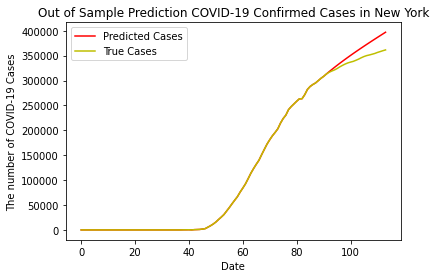

In [6]:
ARIMA_covid_confirmed('New York',1,1,0)

predicted=24389.000000, expected=24708.000000
predicted=24602.000000, expected=24999.000000
predicted=24829.000000, expected=25124.000000
predicted=25066.000000, expected=25623.000000
predicted=25310.000000, expected=26144.000000
predicted=25559.000000, expected=26243.000000
predicted=25810.000000, expected=26612.000000
predicted=26064.000000, expected=26641.000000
predicted=26319.000000, expected=26988.000000
predicted=26575.000000, expected=27284.000000
predicted=26831.000000, expected=27477.000000
predicted=27088.000000, expected=27641.000000
predicted=27345.000000, expected=27878.000000
predicted=27603.000000, expected=28049.000000
predicted=27860.000000, expected=28232.000000
predicted=28118.000000, expected=28339.000000
predicted=28375.000000, expected=28558.000000
predicted=28633.000000, expected=28636.000000
predicted=28891.000000, expected=28743.000000
predicted=29148.000000, expected=28853.000000
predicted=29406.000000, expected=29031.000000
predicted=29664.000000, expected=2

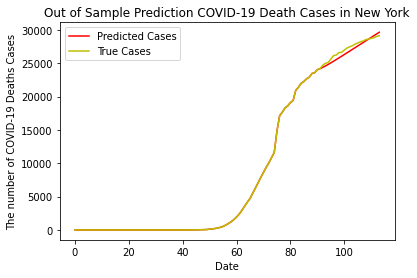

In [7]:
ARIMA_covid_death('New York',1,1,0)

__California__

For predicting confirmed cases, we recommend ARIMA(3,1,0) without using  temperature and for predicting the death cases, we recommend ARIMA(1,1,0) using temperature.

predicted=54914.000000, expected=54903.000000
predicted=56433.000000, expected=55884.000000
predicted=57877.000000, expected=58456.000000
predicted=59359.000000, expected=60616.000000
predicted=60800.000000, expected=62148.000000
predicted=62226.000000, expected=63779.000000
predicted=63644.000000, expected=66558.000000
predicted=65040.000000, expected=67600.000000
predicted=66424.000000, expected=69329.000000
predicted=67792.000000, expected=70978.000000
predicted=69146.000000, expected=72798.000000
predicted=70486.000000, expected=74871.000000
predicted=71812.000000, expected=76693.000000
predicted=73125.000000, expected=78725.000000
predicted=74424.000000, expected=80166.000000
predicted=75710.000000, expected=81457.000000
predicted=76984.000000, expected=83752.000000
predicted=78245.000000, expected=85997.000000
predicted=79494.000000, expected=88031.000000
predicted=80731.000000, expected=90252.000000
predicted=81956.000000, expected=92539.000000
predicted=83170.000000, expected=9

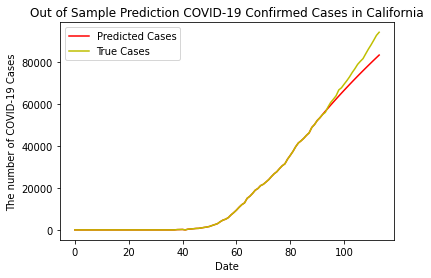

In [9]:
ARIMA_covid_confirmed('California',3,1,0)

predicted=2229.000000, expected=2216.000000
predicted=2279.000000, expected=2278.000000
predicted=2331.000000, expected=2381.000000
predicted=2381.000000, expected=2464.000000
predicted=2439.000000, expected=2535.000000
predicted=2497.000000, expected=2613.000000
predicted=2551.000000, expected=2687.000000
predicted=2591.000000, expected=2716.000000
predicted=2627.000000, expected=2779.000000
predicted=2661.000000, expected=2879.000000
predicted=2693.000000, expected=2957.000000
predicted=2728.000000, expected=3052.000000
predicted=2768.000000, expected=3136.000000
predicted=2811.000000, expected=3208.000000
predicted=2849.000000, expected=3240.000000
predicted=2882.000000, expected=3279.000000
predicted=2913.000000, expected=3403.000000
predicted=2951.000000, expected=3497.000000
predicted=2995.000000, expected=3583.000000
predicted=3034.000000, expected=3666.000000
predicted=3079.000000, expected=3738.000000
predicted=3130.000000, expected=3754.000000


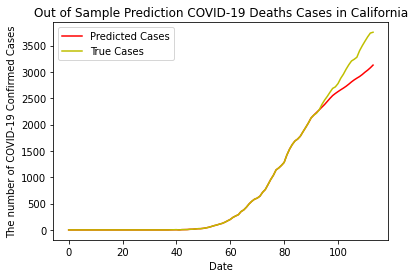

In [10]:
ARIMA_with_temp('California',1,1,0)

__Pennsylvania__

For predicting confirmed cases, we recommend ARIMA(2,1,0) without using temperature and for predicting the death cases, we recommend ARIMA(2,1,0) using temperature.

predicted=51691.000000, expected=51225.000000
predicted=52733.000000, expected=52816.000000
predicted=53817.000000, expected=53864.000000
predicted=54855.000000, expected=54800.000000
predicted=55889.000000, expected=55956.000000
predicted=56900.000000, expected=57371.000000
predicted=57897.000000, expected=58560.000000
predicted=58877.000000, expected=59939.000000
predicted=59843.000000, expected=60459.000000
predicted=60794.000000, expected=61310.000000
predicted=61732.000000, expected=62101.000000
predicted=62655.000000, expected=63105.000000
predicted=63566.000000, expected=64136.000000
predicted=64464.000000, expected=65185.000000
predicted=65350.000000, expected=65700.000000
predicted=66224.000000, expected=66669.000000
predicted=67087.000000, expected=67311.000000
predicted=67938.000000, expected=68126.000000
predicted=68780.000000, expected=69252.000000
predicted=69611.000000, expected=70211.000000
predicted=70433.000000, expected=71009.000000
predicted=71245.000000, expected=7

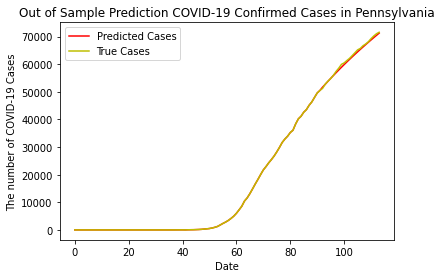

In [11]:
ARIMA_covid_confirmed('Pennsylvania',2,1,0)

predicted=2794.000000, expected=2720.000000
predicted=2863.000000, expected=2838.000000
predicted=2931.000000, expected=3179.000000
predicted=2988.000000, expected=3345.000000
predicted=3046.000000, expected=3589.000000
predicted=3096.000000, expected=3715.000000
predicted=3139.000000, expected=3779.000000
predicted=3185.000000, expected=3806.000000
predicted=3229.000000, expected=3832.000000
predicted=3272.000000, expected=3914.000000
predicted=3315.000000, expected=4094.000000
predicted=3358.000000, expected=4288.000000
predicted=3408.000000, expected=4422.000000
predicted=3455.000000, expected=4480.000000
predicted=3498.000000, expected=4495.000000
predicted=3541.000000, expected=4515.000000
predicted=3582.000000, expected=4628.000000
predicted=3621.000000, expected=4770.000000
predicted=3661.000000, expected=4869.000000
predicted=3703.000000, expected=5010.000000
predicted=3747.000000, expected=5112.000000
predicted=3788.000000, expected=5136.000000


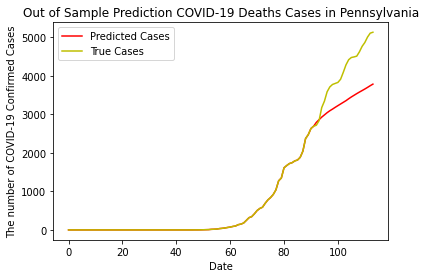

In [13]:
ARIMA_with_temp('Pennsylvania',2,1,0)

__Florida__

For predicting confirmed cases, we recommend ARIMA(2,1,1) without using  temperature and for predicting the death cases, we recommend ARIMA(3,1,1) using temperature.

predicted=36181.000000, expected=36078.000000
predicted=36894.000000, expected=36897.000000
predicted=37600.000000, expected=37439.000000
predicted=38299.000000, expected=38002.000000
predicted=38991.000000, expected=38828.000000
predicted=39677.000000, expected=39199.000000
predicted=40356.000000, expected=40001.000000
predicted=41029.000000, expected=40596.000000
predicted=41695.000000, expected=40982.000000
predicted=42356.000000, expected=41923.000000
predicted=43011.000000, expected=42402.000000
predicted=43660.000000, expected=43210.000000
predicted=44303.000000, expected=44138.000000
predicted=44940.000000, expected=44811.000000
predicted=45573.000000, expected=45588.000000
predicted=46199.000000, expected=46442.000000
predicted=46821.000000, expected=46944.000000
predicted=47438.000000, expected=47471.000000
predicted=48049.000000, expected=48675.000000
predicted=48656.000000, expected=49451.000000
predicted=49258.000000, expected=50127.000000
predicted=49855.000000, expected=5

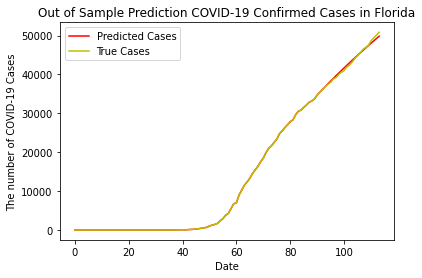

In [14]:
ARIMA_covid_confirmed('Florida',2,1,1)

predicted=1409.000000, expected=1379.000000
predicted=1456.000000, expected=1399.000000
predicted=1502.000000, expected=1471.000000
predicted=1547.000000, expected=1539.000000
predicted=1595.000000, expected=1600.000000
predicted=1642.000000, expected=1669.000000
predicted=1689.000000, expected=1715.000000
predicted=1735.000000, expected=1721.000000
predicted=1781.000000, expected=1735.000000
predicted=1827.000000, expected=1779.000000
predicted=1873.000000, expected=1827.000000
predicted=1919.000000, expected=1875.000000
predicted=1964.000000, expected=1917.000000
predicted=2009.000000, expected=1964.000000
predicted=2054.000000, expected=1973.000000
predicted=2099.000000, expected=1997.000000
predicted=2145.000000, expected=2052.000000
predicted=2191.000000, expected=2096.000000
predicted=2236.000000, expected=2144.000000
predicted=2281.000000, expected=2190.000000
predicted=2327.000000, expected=2233.000000
predicted=2372.000000, expected=2237.000000


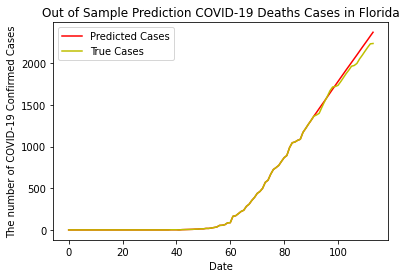

In [15]:
ARIMA_with_temp('Florida',3,1,1)

__Washington__

For predicting confirmed cases, we recommend ARIMA(2,1,1) without using  temperature and for predicting the death cases, we recommend ARIMA(2,1,0) without using temperature.

predicted=15252.000000, expected=15185.000000
predicted=15538.000000, expected=15462.000000
predicted=15805.000000, expected=15594.000000
predicted=16072.000000, expected=15905.000000
predicted=16334.000000, expected=16231.000000
predicted=16593.000000, expected=16388.000000
predicted=16848.000000, expected=16674.000000
predicted=17099.000000, expected=16891.000000
predicted=17347.000000, expected=17122.000000
predicted=17592.000000, expected=17330.000000
predicted=17833.000000, expected=17512.000000
predicted=18071.000000, expected=17773.000000
predicted=18307.000000, expected=17951.000000
predicted=18539.000000, expected=18288.000000
predicted=18769.000000, expected=18433.000000
predicted=18996.000000, expected=18611.000000
predicted=19221.000000, expected=18811.000000
predicted=19443.000000, expected=18971.000000
predicted=19663.000000, expected=19117.000000
predicted=19880.000000, expected=19265.000000
predicted=20095.000000, expected=19265.000000
predicted=20309.000000, expected=1

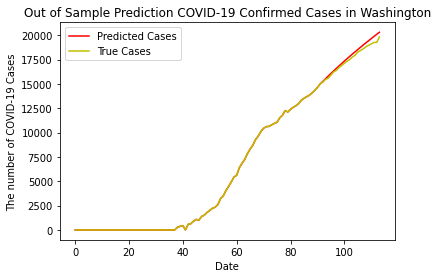

In [17]:
ARIMA_covid_confirmed('Washington',2,1,1)

predicted=838.000000, expected=834.000000
predicted=846.000000, expected=841.000000
predicted=854.000000, expected=862.000000
predicted=862.000000, expected=870.000000
predicted=871.000000, expected=891.000000
predicted=879.000000, expected=905.000000
predicted=887.000000, expected=921.000000
predicted=896.000000, expected=931.000000
predicted=905.000000, expected=945.000000
predicted=913.000000, expected=962.000000
predicted=922.000000, expected=974.000000
predicted=930.000000, expected=983.000000
predicted=939.000000, expected=991.000000
predicted=948.000000, expected=999.000000
predicted=956.000000, expected=1001.000000
predicted=965.000000, expected=1002.000000
predicted=974.000000, expected=1031.000000
predicted=982.000000, expected=1037.000000
predicted=991.000000, expected=1044.000000
predicted=1000.000000, expected=1050.000000
predicted=1009.000000, expected=1050.000000
predicted=1017.000000, expected=1061.000000


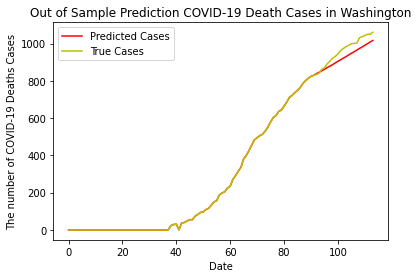

In [16]:
ARIMA_covid_death('Washington',2,1,0)

### Conclusion

Based on the autoregression analysis, we recommend following ARIMA model for predicting the confirmed and death cases in selected states.

1. New York:
   * Confirmed cases: ARIMA(1,1,0) without using temperature 
   * Death cases: ARIMA(1,1,0) without using temperature.

2. California:
   * Confirmed cases: ARIMA(3,1,0) without using temperature 
   * Death cases: ARIMA(1,1,0) using temperature.

3. Pennsylvania:
   * Confirmed cases: ARIMA(2,1,0) without using temperature 
   * Death cases: ARIMA(2,1,0) using temperature.

4. Florida:
   * Confirmed cases: ARIMA(2,1,1) without using temperature 
   * Death cases: ARIMA(3,1,1) using temperature.

5. Washington:
   * Confirmed cases: ARIMA(2,1,1) without using temperature
   * Death cases: ARIMA(2,1,0) without using temperature.